In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

from IPython.display import display_html
from numpy.ma.core import conjugate

In [2]:
pd.__version__

'1.3.5'

# Pre-processing

In [3]:
tol = 1.0e-10

In [4]:
# Utility
def is_equal(a, b):
  if (abs(a.real - b.real) < tol and abs(a.imag - b.imag) < tol):
      return True
  else: return False

# test
a = 1.0e-10 + 2j; b = 1.5e-10 + 2j
assert is_equal(a, b)
a = 1.0e-10 + 2j; b = 2.5e-10 + 2j
assert not is_equal(a, b)

a = 1 + 1.0e-10j; b = 1 + 1.5e-10j
assert is_equal(a, b)
a = 1 + 1.0e-10j; b = 1 + 2.5e-10j
assert not is_equal(a, b)


def highlight_cells(c):
  color = ''
  if (not is_equal(c.imag, 0.0)):
    color = 'orange'
  if (
      is_equal(c.imag, 0j) and
      not is_equal(c.real, 0)
  ):
    color = 'lightgreen' 
  return 'background-color: {}'.format(color)


def view_solutions(sample):
  return pd.DataFrame(sample['All_sols'], columns=sample['variables']).style.applymap(highlight_cells)

def display_dict(d):
  for (k, v) in d.items():
    print(k, " : ", v)

In [5]:
# text parsing
def parse(x):
  if len(x) > 0:
    return eval(x[3:])
  else:
    return None

def parse1(x):
  if len(x) > 0:
    l = parse(x)
    return l[1]
  else:
    return None

def parse_complex(s):
  M = []
  def func(s):
    t = s.replace('im', 'j')
    return eval(t)

  if len(s) > 0:
    s = s[19:]
    s = s[:-1]
    l = s.split("], ")
    l[-1] = l[-1][:-1]
    for x in l:
      v = []
      xx = x[1:].split(",")
      for yy in xx:
        c = func(yy)
        r = c.real
        im = c.imag
        if abs(r) < tol:
          r = 0.0
        if abs(im) < tol:
          im = 0.0
        v.append(complex(r, im))
      M.append(v)
    return M
  else:
    return None

def parse_vars(s):
  if len(s) > 0:
    s = s[9:]
    s = s[:-1]
    return s.split(",")
  else:
    return None

In [6]:
# summary statistics

def mean_(s):
  return int(np.ceil(np.mean(s)))


def get_max(x):
  if len(x) > 0:
    return round(max(x), ndigits=4)
  else:
    return None

def get_min(x):
  if len(x) > 0:
    return round(min(x), ndigits=4)
  else:
    return None

def get_sum(x):
  if len(x) > 0:
    return sum([y == 0 for y in x])
  else:
    return None

def get_N_0(x):
  # no. of solutions with index 0
  return sum([y == 0 for y in x])

def get_N_1(x):
  # no. of solutions with index 1
  if len(x) > 0:
    return sum([y == 1 for y in x])
  else:
    return None

def get_N_2(x):
  # no. of solutions with index 2
  if len(x) > 0:
    return sum([y == 2 for y in x])
  else:
    return None

def get_N_3(x):
  # no. of solutions with index 3
  if len(x) > 0:
    return sum([y == 3 for y in x])
  else:
    return None

def get_N_4(x):
  # no. of solutions with index 4
  if len(x) > 0:
    return sum([y == 4 for y in x])
  else:
    return None

def get_N_C_star(row):
  count = 0
  for v in row:
    zero_count = sum([1 if is_equal(x, 0) else 0 for x in v])
    if zero_count == 0:
      count += 1
  return count

#test
r = [[1, 0], [0, 1]]
assert get_N_C_star(r) == 0
r = [[1, 1],[1, 0]]
assert get_N_C_star(r) == 1

In [7]:
from collections import OrderedDict
class Condition():
  cols = ['convolution','reg','di','H','m','dx','dy','width','stride','Lambda','BKK','N_C','N_R']
  
  def __init__(self):
    od = OrderedDict()
    od['convolution'] = False
    od['reg'] = True
    od['di'] = 2
    od['H'] = 1
    od['m'] = 1
    od['dx'] = 2
    od['dy'] = 2
    od['width'] = 1
    od['stride'] = 1
    od['Lambda'] = 1
    self.dict = od

  def apply(self, data):
    s = ""
    for k, v in self.dict.items():
      s = s + "& (data.{} == {}) ".format(k, v)
    s = "(" + s[1:] + ")"
    
    return data[eval(s)][self.cols]

  def reset(self):
    self.__init__()

In [8]:
# Validate data
file_list = glob.glob("sample_data/math899/*.csv")
if file_list == []:
  raise Exception("No files found! Check directory name...")
else:
  print(len(file_list), " files found...")

for file in file_list:
  # print(file)
  temp = pd.read_csv(file, delimiter="&")
  dx = int(file[36:37])
  dy = int(file[39:40])
  instance_Id = file[-23:-4]
  vc = temp[['dx', 'dy']].value_counts()
  try:
    assert dx == vc.index[0][0]
    assert dy == vc.index[0][1]
    assert(vc.values[0]==100)
  except Exception as e:
    print("Error when reading file: ", file)
    print(e)
    print("value counts returned: \n", vc)

1  files found...


In [9]:
# read validated data
data = pd.DataFrame()
for file in file_list:
  data_temp = pd.read_csv(file, delimiter="&")
  data = pd.concat([data, data_temp])

In [19]:
data.columns

Index(['No.', 'H', 'convolution', 'di', 'dx', 'dy', 'fix_seed', 'm', 'reg',
       'reg_dist_params', 'reg_parameterized', 'runcount',
       'start_params_complex', 'stride', 'width', 'x_dist_params',
       'x_parameterized', 'y_dist_params', 'y_parameterized', 'variables', 'n',
       'CBB', 'BKK', 'N_C', 'N_DM', 'N_R', 'Real_sols', 'All_sols', 'L_values',
       'Idx_vals'],
      dtype='object')

In [20]:
# clean and format list-like entries
data = data.assign(
    variables = data.variables.apply(parse_vars),
    All_sols = data.All_sols.apply(parse_complex),
    Real_sols = data.Real_sols.apply(parse),
    L_values = data.L_values.apply(parse),
    Idx_vals = data.Idx_vals.apply(parse),
    Lambda = data.reg_dist_params.apply(parse1) # note parse1
)

In [21]:
# generate first order summary columns
data = data.assign(
    L_min = data.L_values.apply(get_min),
    L_max = data.L_values.apply(get_max),
    Idx_max = data.Idx_vals.apply(get_max),
    N_C_star = data.All_sols.apply(get_N_C_star),
    N_0 = data.Idx_vals.apply(get_N_0),
    N_1 = data.Idx_vals.apply(get_N_1),
    N_2 = data.Idx_vals.apply(get_N_2),
    N_3 = data.Idx_vals.apply(get_N_3),
    N_4 = data.Idx_vals.apply(get_N_4)
)            

In [22]:
# generate second order summary columns
data = data.assign(N1_N = data['N_1']/data['N_R'])

In [23]:
# data.columns

In [24]:
data.shape

(5600, 41)

# Analysis

## Networks with H=1, m=1

In [25]:
def get_subspaces(sample, real_only=False):
  """Find distinct subspaces in the solution set."""
  d = dict()
  if real_only:
    col = 'Real_sols'
  else:
    col = 'All_sols'
  for v in sample[col]:
    k = str([1 if not is_equal(x, 0) else 0 for x in v])
    if k in d.keys():
      d[k] += 1
    else:
      d[k] = 1

  # i = 65
  # for k in d.keys():
  #   print(chr(i), k)
  #   i += 1
  
  return d

In [26]:
def orthogonal(u1, u2):
  """Check if a given pair of subspaces are orthogonal."""
  if np.dot(u1, u2) == 0:
    return True
  else:
    return False

# test
u1 = [1, 0, 1, 0]
u2 = [0, 1, 0, 1]
assert orthogonal(u1, u2)

u1 = [1, 0, 1, 0]
u2 = [1, 1, 0, 1]
assert not orthogonal(u1, u2)


def dimension(u1):
  """Compute the dimension of a subspace."""
  return sum(u1)
# test
assert dimension([1, 1, 0, 1]) == 3


def contains(sup, sub):
  """True if sup contains sub. False otherwise."""
  if sum(sup) < sum(sub):
    return False

  if len(sup) != len(sub):
    raise Exception("cannot compare lists of different lengths!")

  for i in range(len(sub)):
    if sub[i] == 1:
      if sup[i] != 1:
        return False

  return True

# test
sup = [1, 0, 0, 1]
sub = [1, 0, 0, 0]
assert contains(sup, sub)

sup = [1, 0, 0, 1]
sub = [1, 0, 1, 0]
assert not contains(sup, sub)

sup = [1, 0, 0]
sub = [1, 1, 0]
assert not contains(sup, sub)



def get_orth_pairs(d):
  l = list(d.keys())
  orth_pairs = []
  for i in range(len(l)):
    for j in range(i+1, len(l)):
      u1 = np.array(eval(l[i]))
      u2 = np.array(eval(l[j]))
      if np.dot(u1, u2) == 0:
        orth_pairs.append((u1, u2))
  return orth_pairs

In [27]:
def get_weight_matrices(sol, di, H, dx, dy):
  v = np.array(sol)
  n = di * dx + (H -1) * di * di + dy * di

  if len(v) != n:
    raise Exception(
        "Length of solution vector {} does not match the architecture\n di={}; H={}; dx={}; dy={}.".format(n, di, H, dx, dy))
  pos = 0
  W_list = []
  for i in range(H+1):
    if i == 0:
      W = v[pos : di*dx].reshape(di, dx)
      pos = pos + di*dx
      W_list.append(W)
    elif i == H:
      W = v[pos: ].reshape(dy, di)
      pos = pos + di*dx
      W_list.append(W)
    else:
      W = v[pos: pos + di*di].reshape(di, di)
      pos = pos + di*di
      W_list.append(W)
  return W_list

#test
v = [1, 2, 3, 4]; di=2; H=1; dx=1; dy=1
W_list = get_weight_matrices(v, di, H, dx, dy)
assert W_list[0].shape == (2, 1)
assert W_list[0][0] == [1]
assert W_list[0][1] == [2]

assert W_list[1].shape == (1, 2)
assert W_list[1][0][0] == 3
assert W_list[1][0][1] == 4

v = [1, 2, 3, 4, 5, 6, 7, 8]; di=2; H=2; dx=1; dy=1
W_list = get_weight_matrices(v, di, H, dx, dy)
assert W_list[0].shape == (2, 1)
assert W_list[1].shape == (2, 2)
assert W_list[2].shape == (1, 2)

In [28]:
def prettify(W, caption=""):
  styler = W.style.set_table_styles(
    [{'selector': 'thead', 'props': [('display', 'none')]}],
    axis=0)
  styler.hide_index()
  styler.set_table_attributes("style='display:inline'")
  styler.set_caption(caption)
  return styler

In [29]:
def format_weight_matrices(W_list):
  W_temp = W_list.copy()
  W_temp.reverse()
  s = ''
  i = len(W_temp)
  for W in W_temp:
    cap = "W"+str(i)
    styler = prettify(pd.DataFrame(W), caption=cap)
    s += styler._repr_html_()
    i -= 1
  return s

In [30]:
def analyze(sample):
  subs = get_subspaces(sample, real_only=False)

  for k, v in subs.items():
    W_list = get_weight_matrices(eval(k), sample.di, sample.H, sample.dx, sample.dy)
    stl2 = format_weight_matrices(W_list)

    # print stuff
    display_html(stl2, raw=True)
    print("subspace dim: {}".format(dimension(eval(k))))
    print("solution count: {}\n\n".format(v))

In [31]:
sample = data[(data.di==2) &
              (data.H==1) &
              (data.m==1) &
              (data.dx==2) &
              (data.dy==2)].loc[62]

In [32]:
case = data[(data.di==2) &
              (data.H==1) &
              (data.m==1) &
              (data.dx==2) &
              (data.dy==2)]

### Analyzing the case

In [33]:
case.columns

Index(['No.', 'H', 'convolution', 'di', 'dx', 'dy', 'fix_seed', 'm', 'reg',
       'reg_dist_params', 'reg_parameterized', 'runcount',
       'start_params_complex', 'stride', 'width', 'x_dist_params',
       'x_parameterized', 'y_dist_params', 'y_parameterized', 'variables', 'n',
       'CBB', 'BKK', 'N_C', 'N_DM', 'N_R', 'Real_sols', 'All_sols', 'L_values',
       'Idx_vals', 'Lambda', 'L_min', 'L_max', 'Idx_max', 'N_C_star', 'N_0',
       'N_1', 'N_2', 'N_3', 'N_4', 'N1_N'],
      dtype='object')

In [34]:
case.N_R.max()

9

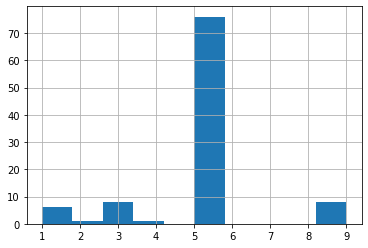

In [35]:
case.N_R.hist()

In [36]:
d = dict()
for i in range(0, case.N_R.max()+1):
  d[i] = 0
for x in case.N_R:
    d[x] += 1

print(d.keys())
print(d.values())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_values([0, 6, 1, 8, 1, 76, 0, 0, 0, 8])


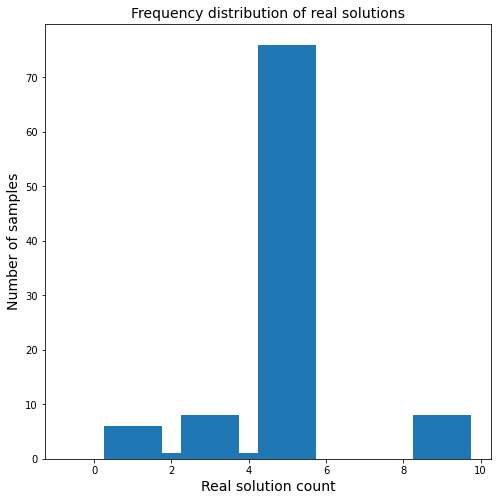

In [37]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (8, 8))

plt.bar(d.keys(), d.values(), width=1.5)
plt.xlabel("Real solution count", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.title("Frequency distribution of real solutions", fontsize=14)
plt.show()

In [38]:
counts, bins = np.histogram(case.N_R)

In [39]:
counts, bins

(array([ 6,  1,  8,  1,  0, 76,  0,  0,  0,  8]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]))

In [40]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

In [41]:
def get_B_C_start(d, p):
  return (4*p)**d

def get_B_C(d,p):
  sum = 0
  for r in range(1, d+1):
    sum += ncr(d,r)*get_B_C_start(r, p)
  return sum

In [54]:
##### PRINT CASE #####
rows = []
for H in range(1, 2):
  for m in range(1, 2):
    for di in range(3, 4):
      for dy in range(1, 5):
        for dx in range(1, 5):
          case = data[(data.di==di) &
                (data.H==H) &
                (data.m==m) &
                (data.dx==dx) &
                (data.dy==dy)]
          if len(case) > 0:
            N_R_max = case.N_R.max()
            B_C_start = get_B_C_start(di, dy)
            B_C = get_B_C(di, dy) + 1

            case = case[['di', 'H', 'm', 'dx', 'dy', 'n','CBB', 'BKK', 'N_C', 'N_C_star']]
            # print(" ############ di={}, H={}, m={}, dx={}, dy={} ############\n".format(di, H, m, dx, dy))

            # take the max of each column to avoid discrepancies
            r = case.max()

            # add entries
            r = r.to_dict()
            r["B_C"] = B_C
            r["B_C_start"] = B_C_start 
            r["N_R_max"] = N_R_max

            # append
            row = pd.Series(r)
            rows.append(row)
          else:
            pass
          # break
        # break
      # break
    # break
  # break

In [55]:
df_table = pd.DataFrame(rows)

In [56]:
df_table[['H',
          'm',
          'di',
          'dx',
          'dy',
          'n',
          'CBB',
          'BKK',
          'B_C',
          'B_C_start',
          'N_C',
          'N_C_star',
          'N_R_max']]

,H,m,di,dx,dy,n,CBB,BKK,B_C,B_C_start,N_C,N_C_star,N_R_max
0,1,1,3,1,1,6,729,125,125,64,13,0,7
1,1,1,3,2,1,9,19683,729,125,64,13,0,7
2,1,1,3,3,1,12,531441,2197,125,64,13,0,7
3,1,1,3,4,1,15,14348907,4913,125,64,13,0,7
4,1,1,3,1,2,9,19683,729,729,512,73,0,15
5,1,1,3,2,2,12,531441,35937,729,512,73,0,15
6,1,1,3,3,2,15,14348907,389017,729,512,73,0,15
7,1,1,3,4,2,18,387420489,2146689,729,512,73,0,15
8,1,1,3,1,3,12,531441,2197,2197,1728,245,64,19
9,1,1,3,2,3,15,14348907,389017,2197,1728,245,64,23


### Analyzing the sample

In [57]:
view_solutions(sample)

,w111,w112,w121,w122,w211,w212,w221,w222
0,0.000000+0.000000j,0.000000+0.000000j,-0.002552-0.004813j,0.159315+0.300498j,0.000000+0.000000j,0.276924+0.364432j,0.000000+0.000000j,-1.321782+1.005523j
1,0.220270+0.000000j,-0.735825+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.506085+0.000000j,0.000000+0.000000j,0.280227+0.000000j,0.000000+0.000000j
2,0.200472-0.032028j,-0.669690+0.106992j,0.004236+0.006432j,-0.264464-0.401606j,-0.554579+0.088601j,-0.174839-0.265505j,-0.020808-0.130242j,0.958125-0.630941j
3,0.018758-0.342301j,-0.062661+1.143478j,0.006227+0.004375j,-0.388824-0.273157j,0.051890-0.946929j,0.257054+0.180586j,-0.222384-0.012186j,0.651682-0.927631j
4,0.000000-0.361684j,0.000000+1.208226j,0.000000+0.000000j,0.000000+0.000000j,0.000000-0.796969j,0.000000+0.000000j,0.000000+0.509245j,0.000000+0.000000j
5,0.000000+0.000000j,0.000000+0.000000j,0.002552+0.004813j,-0.159315-0.300498j,0.000000+0.000000j,-0.276924-0.364432j,0.000000+0.000000j,1.321782-1.005523j
6,-0.018758-0.342301j,0.062661+1.143478j,0.006227-0.004375j,-0.388824+0.273157j,-0.051890-0.946929j,0.257054-0.180586j,0.222384-0.012186j,0.651682+0.927631j
7,-0.018758+0.342301j,0.062661-1.143478j,-0.006227-0.004375j,0.388824+0.273157j,-0.051890+0.946929j,-0.257054-0.180586j,0.222384+0.012186j,-0.651682+0.927631j
8,0.000000+0.000000j,0.000000+0.000000j,-0.002552+0.004813j,0.159315-0.300498j,0.000000+0.000000j,0.276924-0.364432j,0.000000+0.000000j,-1.321782-1.005523j
9,-0.018758+0.342301j,0.062661-1.143478j,0.006227+0.004375j,-0.388824-0.273157j,-0.051890+0.946929j,0.257054+0.180586j,0.222384+0.012186j,0.651682-0.927631j


In [58]:
analyze(sample)

0,1
0,1
0,1
0,1
0,0
1,1


subspace dim: 4
solution count: 8




0,1
1,0
1,0
0,1
1,1
0,0


subspace dim: 4
solution count: 8




0,1
1,1
1,1
0,1
1,1
1,1


subspace dim: 8
solution count: 16




0,1
0,0
0,0
0,1
0,0
0,0


subspace dim: 0
solution count: 1




In [ ]:
# ~ PRINT COORDINATE DECOMPOSITIONS ~ #
for di in range(1, 4):
  for H in range(1, 4):
    for dx in range(1, 4):
      for dy in range(1, 4):
        try:
          sample = data[(data.di==di) &
                        (data.H==H) &
                        (data.m==1) &
                        (data.dx==dx) &
                        (data.dy==dy)].loc[67]
          print(" ####################### di={}, H={}, m={}, dx={}, dy={} #####################\n".format(di, H, 1, dx, dy))
          analyze(sample)
        except:
          print("Missing: di={}, H={}, dx={}, dy={}. Ignoring...\n".format(di, H, dx, dy))
          pass

 ####################### di=1, H=1, m=1, dx=1, dy=1 #####################



0
1
0
1


subspace dim: 2
solution count: 4




0
0
0
0


subspace dim: 0
solution count: 1


 ####################### di=1, H=1, m=1, dx=1, dy=2 #####################



0
1
1
0
1


subspace dim: 3
solution count: 8




0
0
0
0
0


subspace dim: 0
solution count: 1


 ####################### di=1, H=1, m=1, dx=1, dy=3 #####################



0
1
1
1
0
1


subspace dim: 4
solution count: 12




0
0
0
0
0
0


subspace dim: 0
solution count: 1


 ####################### di=1, H=1, m=1, dx=2, dy=1 #####################



W2 
 
 
 0 
 
 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1

subspace dim: 3
solution count: 4




W2 
 
 
 0 
 
 
 
 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=1, H=1, m=1, dx=2, dy=2 #####################



W2 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1

subspace dim: 4
solution count: 8




W2 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=1, H=1, m=1, dx=2, dy=3 #####################



W2 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1

subspace dim: 5
solution count: 12




W2 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=1, H=1, m=1, dx=3, dy=1 #####################



W2 
 
 
 0 
 
 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1

subspace dim: 4
solution count: 4




W2 
 
 
 0 
 
 
 
 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=1, H=1, m=1, dx=3, dy=2 #####################



W2 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1

subspace dim: 5
solution count: 8




W2 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=1, H=1, m=1, dx=3, dy=3 #####################



W2 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1

subspace dim: 6
solution count: 12




W2 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=1, H=2, m=1, dx=1, dy=1 #####################



0
1
0
1
0
1


subspace dim: 3
solution count: 16


 ####################### di=1, H=2, m=1, dx=1, dy=2 #####################



0
1
1
0
1
0
1


subspace dim: 4
solution count: 32


Missing: di=1, H=2, dx=1, dy=3. Ignoring...

 ####################### di=1, H=2, m=1, dx=2, dy=1 #####################



W3 
 
 
 0 
 
 
 
 
 1 
 
 
 

 
 W2 
 
 
 0 
 
 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1

subspace dim: 4
solution count: 16


 ####################### di=1, H=2, m=1, dx=2, dy=2 #####################



W3 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 

 
 W2 
 
 
 0 
 
 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1

subspace dim: 5
solution count: 32




W3 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 

 
 W2 
 
 
 0 
 
 
 
 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0

subspace dim: 0
solution count: 1


Missing: di=1, H=2, dx=2, dy=3. Ignoring...

 ####################### di=1, H=2, m=1, dx=3, dy=1 #####################



W3 
 
 
 0 
 
 
 
 
 1 
 
 
 

 
 W2 
 
 
 0 
 
 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1

subspace dim: 5
solution count: 16


 ####################### di=1, H=2, m=1, dx=3, dy=2 #####################



W3 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 

 
 W2 
 
 
 0 
 
 
 
 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1

subspace dim: 6
solution count: 32


Missing: di=1, H=2, dx=3, dy=3. Ignoring...

Missing: di=1, H=3, dx=1, dy=1. Ignoring...

Missing: di=1, H=3, dx=1, dy=2. Ignoring...

Missing: di=1, H=3, dx=1, dy=3. Ignoring...

Missing: di=1, H=3, dx=2, dy=1. Ignoring...

Missing: di=1, H=3, dx=2, dy=2. Ignoring...

Missing: di=1, H=3, dx=2, dy=3. Ignoring...

Missing: di=1, H=3, dx=3, dy=1. Ignoring...

Missing: di=1, H=3, dx=3, dy=2. Ignoring...

Missing: di=1, H=3, dx=3, dy=3. Ignoring...

 ####################### di=2, H=1, m=1, dx=1, dy=1 #####################



W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 2
solution count: 4




W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 2
solution count: 4


 ####################### di=2, H=1, m=1, dx=1, dy=2 #####################



W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1

subspace dim: 6
solution count: 16




W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 3
solution count: 8




W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 3
solution count: 8




W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0

subspace dim: 0
solution count: 1


 ####################### di=2, H=1, m=1, dx=1, dy=3 #####################



W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0

subspace dim: 0
solution count: 1




W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1

subspace dim: 8
solution count: 48




W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 4
solution count: 12




W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 4
solution count: 12


 ####################### di=2, H=1, m=1, dx=2, dy=1 #####################



0,1
1,0
0,1
1,1
0,0


subspace dim: 3
solution count: 4




0,1
0,1
0,1
0,0
1,1


subspace dim: 3
solution count: 4


 ####################### di=2, H=1, m=1, dx=2, dy=2 #####################



0,1
0,1
0,1
0,1
0,0
1,1


subspace dim: 4
solution count: 8




0,1
1,1
1,1
0,1
1,1
1,1


subspace dim: 8
solution count: 16




0,1
1,0
1,0
0,1
1,1
0,0


subspace dim: 4
solution count: 8




0,1
0,0
0,0
0,1
0,0
0,0


subspace dim: 0
solution count: 1


 ####################### di=2, H=1, m=1, dx=2, dy=3 #####################



0,1
0,0
0,0
0,0
0,1
0,0
0,0


subspace dim: 0
solution count: 1




0,1
1,1
1,1
1,1
0,1
1,1
1,1


subspace dim: 10
solution count: 48




0,1
1,0
1,0
1,0
0,1
1,1
0,0


subspace dim: 5
solution count: 12




0,1
0,1
0,1
0,1
0,1
0,0
1,1


subspace dim: 5
solution count: 12


 ####################### di=2, H=1, m=1, dx=3, dy=1 #####################



W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 0 
 0 
 0

subspace dim: 4
solution count: 4




W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 1 
 1 
 1

subspace dim: 4
solution count: 4




W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=2, H=1, m=1, dx=3, dy=2 #####################



W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 1 
 1 
 1

subspace dim: 10
solution count: 16




W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 1 
 1 
 1

subspace dim: 5
solution count: 8




W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 0 
 0 
 0

subspace dim: 5
solution count: 8




W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=2, H=1, m=1, dx=3, dy=3 #####################



W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0

subspace dim: 0
solution count: 1




W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 1 
 1 
 1

subspace dim: 12
solution count: 48




W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 1 
 1 
 1

subspace dim: 6
solution count: 12




W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 0 
 0 
 0

subspace dim: 6
solution count: 12


 ####################### di=2, H=2, m=1, dx=1, dy=1 #####################



W3 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 3
solution count: 16


 ####################### di=2, H=2, m=1, dx=1, dy=2 #####################



W3 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 4
solution count: 32




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1

subspace dim: 10
solution count: 384




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 4
solution count: 32




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 4
solution count: 32




W3 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 4
solution count: 32




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 7
solution count: 64




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 7
solution count: 64


Missing: di=2, H=2, dx=1, dy=3. Ignoring...

 ####################### di=2, H=2, m=1, dx=2, dy=1 #####################



0,1
0,1
0,1
0,0
0,1
0,1
0,0
1,1


subspace dim: 4
solution count: 16




0,1
1,0
0,1
1,0
0,0
0,1
1,1
0,0


subspace dim: 4
solution count: 16




0,1
1,1
0,1
1,1
1,1
0,1
1,1
1,1


subspace dim: 10
solution count: 64




0,1
1,0
0,1
0,1
0,0
0,1
0,0
1,1


subspace dim: 4
solution count: 16




0,1
0,1
0,1
0,0
1,0
0,1
1,1
0,0


subspace dim: 4
solution count: 16


 ####################### di=2, H=2, m=1, dx=2, dy=2 #####################



0,1
1,0
1,0
0,1
0,1
0,0
0,1
0,0
1,1


subspace dim: 5
solution count: 32




0,1
1,1
1,1
0,1
1,1
1,1
0,1
1,1
1,1


subspace dim: 12
solution count: 384




0,1
0,1
0,1
0,1
0,0
1,0
0,1
1,1
0,0


subspace dim: 5
solution count: 32




0,1
1,1
1,1
0,1
1,0
1,0
0,1
1,1
0,0


subspace dim: 8
solution count: 64




0,1
1,1
1,1
0,1
0,1
0,1
0,1
0,0
1,1


subspace dim: 8
solution count: 64




0,1
1,0
1,0
0,1
1,0
0,0
0,1
1,1
0,0


subspace dim: 5
solution count: 32




0,1
0,1
0,1
0,1
0,0
0,1
0,1
0,0
1,1


subspace dim: 5
solution count: 32


Missing: di=2, H=2, dx=2, dy=3. Ignoring...

 ####################### di=2, H=2, m=1, dx=3, dy=1 #####################



W3 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 0 
 0 
 0

subspace dim: 5
solution count: 16




W3 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 0 
 0 
 0

subspace dim: 5
solution count: 16




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 1 
 1 
 1

subspace dim: 12
solution count: 64




W3 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 1 
 1 
 1

subspace dim: 5
solution count: 16




W3 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 1 
 1 
 1

subspace dim: 5
solution count: 16


Missing: di=2, H=2, dx=3, dy=2. Ignoring...

Missing: di=2, H=2, dx=3, dy=3. Ignoring...

 ####################### di=2, H=3, m=1, dx=1, dy=1 #####################



W4 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 9
solution count: 192




W4 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1

subspace dim: 12
solution count: 768




W4 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1

subspace dim: 9
solution count: 192




W4 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 0 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 4
solution count: 48




W4 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 0 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1

subspace dim: 9
solution count: 192




W4 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 4
solution count: 48




W4 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 4
solution count: 48




W4 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 9
solution count: 192




W4 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 4
solution count: 48




W4 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 0 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 4
solution count: 48




W4 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 0 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1

subspace dim: 4
solution count: 48




W4 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 1 
 0 
 
 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 4
solution count: 48




W4 
 
 
 0 
 1 
 
 
 
 
 0 
 1 
 
 
 

 
 W3 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0

subspace dim: 4
solution count: 48


Missing: di=2, H=3, dx=1, dy=2. Ignoring...

Missing: di=2, H=3, dx=1, dy=3. Ignoring...

Missing: di=2, H=3, dx=2, dy=1. Ignoring...

Missing: di=2, H=3, dx=2, dy=2. Ignoring...

Missing: di=2, H=3, dx=2, dy=3. Ignoring...

Missing: di=2, H=3, dx=3, dy=1. Ignoring...

Missing: di=2, H=3, dx=3, dy=2. Ignoring...

Missing: di=2, H=3, dx=3, dy=3. Ignoring...

 ####################### di=3, H=1, m=1, dx=1, dy=1 #####################



W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 0

subspace dim: 2
solution count: 4




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 1

subspace dim: 2
solution count: 4




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 0

subspace dim: 2
solution count: 4


 ####################### di=3, H=1, m=1, dx=1, dy=2 #####################



W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 0 
 
 
 1 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 0

subspace dim: 6
solution count: 16




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 0 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 1

subspace dim: 3
solution count: 8




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 0 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 0

subspace dim: 3
solution count: 8




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 1 
 
 
 0 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 1

subspace dim: 6
solution count: 16




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 1 
 
 
 1 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 1

subspace dim: 6
solution count: 16




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 1 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 0

subspace dim: 3
solution count: 8




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 0

subspace dim: 0
solution count: 1


 ####################### di=3, H=1, m=1, dx=1, dy=3 #####################



W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 0 
 
 
 1 
 1 
 0 
 
 
 1 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 0

subspace dim: 8
solution count: 48




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 1 
 1 
 1 
 
 
 1 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 1

subspace dim: 12
solution count: 64




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 1 
 
 
 1 
 0 
 1 
 
 
 1 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 1

subspace dim: 8
solution count: 48




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 0 
 0 
 1 
 
 
 0 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 1

subspace dim: 4
solution count: 12




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 1 
 
 
 0 
 1 
 1 
 
 
 0 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 1

subspace dim: 8
solution count: 48




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 0 
 1 
 0 
 
 
 0 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 0

subspace dim: 4
solution count: 12




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 0

subspace dim: 0
solution count: 1




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 1 
 0 
 0 
 
 
 1 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 0

subspace dim: 4
solution count: 12


 ####################### di=3, H=1, m=1, dx=2, dy=1 #####################



W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 0 
 0 
 
 
 0 
 0

subspace dim: 3
solution count: 4




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 1 
 
 
 0 
 0

subspace dim: 3
solution count: 4




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 1 
 1

subspace dim: 3
solution count: 4




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=3, H=1, m=1, dx=2, dy=2 #####################



W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 0 
 
 
 1 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 0 
 0

subspace dim: 8
solution count: 16




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 0 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 1 
 
 
 0 
 0

subspace dim: 4
solution count: 8




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 1 
 
 
 1 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 0 
 0 
 
 
 1 
 1

subspace dim: 8
solution count: 16




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 1 
 
 
 0 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 1 
 
 
 1 
 1

subspace dim: 8
solution count: 16




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 1 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 0 
 0 
 
 
 0 
 0

subspace dim: 4
solution count: 8




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 0 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 1 
 1

subspace dim: 4
solution count: 8




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=3, H=1, m=1, dx=2, dy=3 #####################



W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 1 
 
 
 1 
 0 
 1 
 
 
 1 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 0 
 0 
 
 
 1 
 1

subspace dim: 10
solution count: 48




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 1 
 
 
 0 
 1 
 1 
 
 
 0 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 1 
 
 
 1 
 1

subspace dim: 10
solution count: 48




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 1 
 1 
 1 
 
 
 1 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 1 
 1

subspace dim: 15
solution count: 64




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 1 
 0 
 0 
 
 
 1 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 0 
 0 
 
 
 0 
 0

subspace dim: 5
solution count: 12




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 0 
 
 
 1 
 1 
 0 
 
 
 1 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 1 
 1 
 
 
 1 
 1 
 
 
 0 
 0

subspace dim: 10
solution count: 48




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 0 
 0 
 1 
 
 
 0 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 1 
 1

subspace dim: 5
solution count: 12




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 0 
 1 
 0 
 
 
 0 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 1 
 1 
 
 
 0 
 0

subspace dim: 5
solution count: 12




W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 1 
 
 
 
 
 0 
 0 
 
 
 0 
 0 
 
 
 0 
 0

subspace dim: 0
solution count: 1


 ####################### di=3, H=1, m=1, dx=3, dy=1 #####################



0,1,2
1,0,0
0,1,2
1,1,1
0,0,0
0,0,0


subspace dim: 4
solution count: 4




0,1,2
0,0,1
0,1,2
0,0,0
0,0,0
1,1,1


subspace dim: 4
solution count: 4




0,1,2
0,1,0
0,1,2
0,0,0
1,1,1
0,0,0


subspace dim: 4
solution count: 4




0,1,2
0,0,0
0,1,2
0,0,0
0,0,0
0,0,0


subspace dim: 0
solution count: 1


 ####################### di=3, H=1, m=1, dx=3, dy=2 #####################



0,1,2
1,0,0
1,0,0
0,1,2
1,1,1
0,0,0
0,0,0


subspace dim: 5
solution count: 8




0,1,2
1,0,1
1,0,1
0,1,2
1,1,1
0,0,0
1,1,1


subspace dim: 10
solution count: 16




0,1,2
1,1,0
1,1,0
0,1,2
1,1,1
1,1,1
0,0,0


subspace dim: 10
solution count: 16




0,1,2
0,1,1
0,1,1
0,1,2
0,0,0
1,1,1
1,1,1


subspace dim: 10
solution count: 16




0,1,2
0,0,1
0,0,1
0,1,2
0,0,0
0,0,0
1,1,1


subspace dim: 5
solution count: 8




0,1,2
0,1,0
0,1,0
0,1,2
0,0,0
1,1,1
0,0,0


subspace dim: 5
solution count: 8




0,1,2
0,0,0
0,0,0
0,1,2
0,0,0
0,0,0
0,0,0


subspace dim: 0
solution count: 1


Missing: di=3, H=1, dx=3, dy=3. Ignoring...

 ####################### di=3, H=2, m=1, dx=1, dy=1 #####################



W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 1 
 
 
 0 
 0 
 0 
 
 
 0 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 1

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 1 
 
 
 0 
 0 
 0 
 
 
 1 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 1

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 1 
 0 
 1 
 
 
 1 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 1

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 1 
 
 
 1 
 0 
 1 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 1

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 1 
 1 
 0 
 
 
 1 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 0

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 0

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 0 
 
 
 1 
 1 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 0

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 1 
 
 
 1 
 1 
 1 
 
 
 1 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 1

subspace dim: 15
solution count: 256




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 1 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 1

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 1 
 
 
 0 
 1 
 1 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 1

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 0 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 0

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 1 
 1 
 
 
 0 
 1 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 1

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 1 
 0 
 
 
 0 
 0 
 0 
 
 
 1 
 1 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 1 
 
 
 0

subspace dim: 8
solution count: 64




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 1 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 0

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 1 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 1 
 
 
 0

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 0

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 1 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 1 
 
 
 0 
 
 
 0

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 1 
 0 
 0 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 1

subspace dim: 3
solution count: 16




W3 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 1 
 
 
 

 
 W2 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 
 
 0 
 0 
 1 
 
 
 

 
 W1 
 
 
 0 
 
 
 
 
 0 
 
 
 0 
 
 
 1

subspace dim: 3
solution count: 16


Missing: di=3, H=2, dx=1, dy=2. Ignoring...

Missing: di=3, H=2, dx=1, dy=3. Ignoring...

Missing: di=3, H=2, dx=2, dy=1. Ignoring...

Missing: di=3, H=2, dx=2, dy=2. Ignoring...

Missing: di=3, H=2, dx=2, dy=3. Ignoring...

Missing: di=3, H=2, dx=3, dy=1. Ignoring...

Missing: di=3, H=2, dx=3, dy=2. Ignoring...

Missing: di=3, H=2, dx=3, dy=3. Ignoring...

Missing: di=3, H=3, dx=1, dy=1. Ignoring...

Missing: di=3, H=3, dx=1, dy=2. Ignoring...

Missing: di=3, H=3, dx=1, dy=3. Ignoring...

Missing: di=3, H=3, dx=2, dy=1. Ignoring...

Missing: di=3, H=3, dx=2, dy=2. Ignoring...

Missing: di=3, H=3, dx=2, dy=3. Ignoring...

Missing: di=3, H=3, dx=3, dy=1. Ignoring...

Missing: di=3, H=3, dx=3, dy=2. Ignoring...

Missing: di=3, H=3, dx=3, dy=3. Ignoring...

